<a href="https://colab.research.google.com/github/Buuuuli/AIPI540_individual/blob/main/try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from os.path import join
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT, force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#PROJ ="MyDrive/repos"
#PROJECT_PATH = join(ROOT, PROJ)
#!mkdir "PROJECT_PATH"

In [2]:
!ls

drive  sample_data


In [3]:
%cd /content/drive/"My Drive"/imagetest

/content/drive/My Drive/imagetest


In [4]:
!pip install kaggle

In [5]:

import urllib.request
import zipfile
import copy
import time
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import FashionMNIST
from torchsummary import summary
import cv2 as cv
import glob
from PIL import Image
import pickle as pkl
from tqdm import tqdm
from zipfile import ZipFile
import opendatasets as od
import kaggle

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

OSError: ignored

In [7]:
#od.download("https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000")
kaggle.api.authenticate()

kaggle.api.dataset_download_files('skin-cancer-mnist-ham10000', unzip=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mengkq
Your Kaggle Key: ··········


100%|██████████| 5.20G/5.20G [01:14<00:00, 74.5MB/s]


In [8]:
!ls

skin-cancer-mnist-ham10000


In [13]:
%cd /content/drive/"My Drive"/imagetest/skin-cancer-mnist-ham10000

/content/drive/My Drive/imagetest/skin-cancer-mnist-ham10000


In [26]:
!ls

ham10000_images_part_1	HAM10000_images_part_2	hmnist_28_28_RGB.csv
HAM10000_images_part_1	HAM10000_metadata.csv	hmnist_8_8_L.csv
ham10000_images_part_2	hmnist_28_28_L.csv	hmnist_8_8_RGB.csv


In [19]:
#set the image directory
image_part1 = os.listdir("HAM10000_images_part_1")
image_part2 = os.listdir("HAM10000_images_part_2")

In [20]:
whole_image = image_part1+image_part2

In [22]:
# check what types of image we get
# print the types of image
print(set([x.split(".")[1] for x in whole_image]))


{'jpg'}


In [24]:
# set the transforms
trans = transforms.Compose([
                            transforms.Resize((224, 224)),
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [25]:
# read data
pil_img = []
for img in tqdm(sorted(whole_image)):
    # read image > resize > to Tensor > normalize
    n= trans(Image.open(img))
    pil_img.append(n)

  0%|          | 0/10015 [00:00<?, ?it/s]


FileNotFoundError: ignored

In [28]:
#meta1 = 'https://github.com/Buuuuli/AIPI540_individual/blob/main/metadata/raw_metadata.csv?raw=true'
meta1 = 'HAM10000_metadata.csv'
df = pd.read_csv(meta1,index_col=0)
df = df.sort_values(by=['image_id'])
print(df.head(5))

                 image_id   dx    dx_type   age     sex     localization
lesion_id                                                               
HAM_0000550  ISIC_0024306   nv  follow_up  45.0    male            trunk
HAM_0003577  ISIC_0024307   nv  follow_up  50.0    male  lower extremity
HAM_0001477  ISIC_0024308   nv  follow_up  55.0  female            trunk
HAM_0000484  ISIC_0024309   nv  follow_up  40.0    male            trunk
HAM_0003350  ISIC_0024310  mel      histo  60.0    male            chest


In [ ]:
count = df.dx.value_counts()

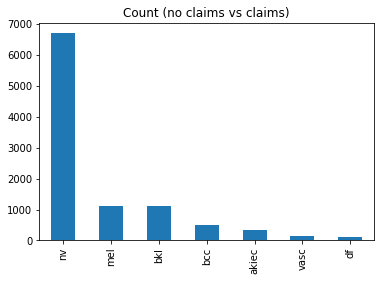

In [ ]:
count.plot(kind='bar', title='Count (no claims vs claims)');

In [ ]:
# group age
bins =[0,10,20,30,40,50,60,70,80,90]
labels = ['children','teenage','young','adult','midage','old1','old2','old3','older']

df['ageGroup'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

df = df.drop("age", axis=1)

In [ ]:
# {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}
dx_dict = dict(enumerate(df['dx'].astype('category').cat.categories))

# {0: 'confocal', 1: 'consensus', 2: 'follow_up', 3: 'histo'}
dx_type_dict = dict(enumerate(df['dx_type'].astype('category').cat.categories))

# {0: 'female', 1: 'male', 2: 'unknown'}
sex_dict = dict(enumerate(df['sex'].astype('category').cat.categories))

# {0: 'abdomen', 1: 'acral', 2: 'back', 3: 'chest', 4: 'ear',
# 5: 'face', 6: 'foot', 7: 'genital', 8: 'hand', 9: 'lower extremity',
# 10: 'neck', 11: 'scalp', 12: 'trunk', 13: 'unknown', 14: 'upper extremity'}
localization_dict = dict(enumerate(df['localization'].astype('category').cat.categories))

# {0: 'children', 1: 'teenage', 2: 'young', 3: 'adult', 4: 'midage',
# 5: 'old', 6: 'old2', 7: 'old3', 8: 'older'}
ageGroup_dict = dict(enumerate(df['ageGroup'].astype('category').cat.categories))

In [ ]:
# encode 'dx','dx_type','sex', 'localization'
for col in ['dx','dx_type','sex','localization','ageGroup']:
    df[col] = df[col].astype('category') # Convert to category type
    df[col] = df[col].cat.codes # Convert to numerical code

In [ ]:
df.head(10)

,image_id,dx,dx_type,sex,localization,ageGroup
lesion_id,,,,,,
HAM_0000550,ISIC_0024306,5,2,1,12,4
HAM_0003577,ISIC_0024307,5,2,1,9,5
HAM_0001477,ISIC_0024308,5,2,0,12,5
HAM_0000484,ISIC_0024309,5,2,1,12,4
HAM_0003350,ISIC_0024310,4,3,1,3,6
HAM_0000981,ISIC_0024311,5,2,0,2,7
HAM_0001359,ISIC_0024312,2,3,1,9,7
HAM_0002869,ISIC_0024313,4,3,0,2,5
HAM_0002198,ISIC_0024314,5,3,1,9,7


In [ ]:
df = df.drop(['dx_type'], axis=1)

In [ ]:
df

,image_id,dx,sex,localization,ageGroup
lesion_id,,,,,
HAM_0000550,ISIC_0024306,5,1,12,4
HAM_0003577,ISIC_0024307,5,1,9,5
HAM_0001477,ISIC_0024308,5,0,12,5
HAM_0000484,ISIC_0024309,5,1,12,4
HAM_0003350,ISIC_0024310,4,1,3,6
...,...,...,...,...,...
HAM_0004304,ISIC_0034316,4,1,14,8
HAM_0006376,ISIC_0034317,4,0,9,7
HAM_0000344,ISIC_0034318,2,1,12,5


In [ ]:
dict_image = {pil_img[i]: df.dx[i] for i in range(len(pil_img))}

In [ ]:
proper_dict = {k:v for k,v in dict_image.items() if v == 2 or v ==4}

In [ ]:
proper_dict

{tensor([[[-0.9020, -0.8849, -0.9020,  ..., -0.7822, -0.8335, -0.7993],
          [-0.8849, -0.8849, -0.8849,  ..., -0.7822, -0.8164, -0.8164],
          [-0.8849, -0.9192, -0.9192,  ..., -0.7993, -0.8164, -0.7993],
          ...,
          [-0.7822, -0.7479, -0.7650,  ..., -0.8678, -0.8678, -0.9020],
          [-0.8164, -0.7993, -0.7993,  ..., -0.8849, -0.8849, -0.8849],
          [-0.7993, -0.8164, -0.8335,  ..., -0.8849, -0.8849, -0.8849]],
 
         [[-1.4405, -1.4755, -1.4755,  ..., -1.5280, -1.5105, -1.5105],
          [-1.4755, -1.4580, -1.4755,  ..., -1.5105, -1.5105, -1.5105],
          [-1.4580, -1.4755, -1.4755,  ..., -1.5105, -1.4930, -1.4930],
          ...,
          [-1.4405, -1.4230, -1.4405,  ..., -1.4930, -1.4755, -1.4755],
          [-1.4405, -1.4405, -1.4405,  ..., -1.4755, -1.4755, -1.4755],
          [-1.4405, -1.4405, -1.4405,  ..., -1.4755, -1.4755, -1.4755]],
 
         [[-1.1596, -1.1247, -1.1421,  ..., -1.2293, -1.2467, -1.2467],
          [-1.1770, -1.1596,

In [ ]:
newdf = df.loc[df['dx'].isin([2, 4])]

In [ ]:
newdf.head()

,image_id,dx,sex,localization,ageGroup
lesion_id,,,,,
HAM_0003350,ISIC_0024310,4,1,3,6
HAM_0001359,ISIC_0024312,2,1,9,7
HAM_0002869,ISIC_0024313,4,0,2,5
HAM_0007538,ISIC_0024315,4,1,12,5
HAM_0002493,ISIC_0024323,4,1,9,5


In [ ]:
image_fulldata_list = list(proper_dict.items())

In [ ]:
train_image_list_with_target, test_image_list_with_target = train_test_split(image_fulldata_list, test_size=0.2,shuffle=True ,random_state=45)

In [ ]:
train_image_list_with_target

[(tensor([[[ 1.9235,  1.9407,  1.9407,  ...,  1.4440,  1.1529,  0.7933],
           [ 1.9235,  1.9407,  1.9235,  ...,  1.4269,  1.0844,  0.7591],
           [ 1.9064,  1.9407,  1.9920,  ...,  1.4269,  0.8447,  0.6392],
           ...,
           [ 1.8379,  1.9235,  1.9235,  ...,  1.5468,  1.4783,  1.4783],
           [ 1.7694,  1.8722,  1.8379,  ...,  1.5639,  1.4954,  1.4954],
           [ 1.8037,  1.7694,  1.7352,  ...,  1.5810,  1.5125,  1.4783]],
  
          [[ 0.7829,  0.7829,  0.8354,  ...,  0.0476, -0.0574, -0.3025],
           [ 0.7654,  0.7829,  0.8529,  ...,  0.0651, -0.1450, -0.3550],
           [ 0.7829,  0.7829,  0.8529,  ...,  0.0476, -0.3550, -0.4251],
           ...,
           [ 0.9230,  1.0105,  1.0105,  ...,  0.3978,  0.3277,  0.3102],
           [ 0.9055,  0.9580,  0.8880,  ...,  0.4503,  0.3452,  0.3277],
           [ 0.8880,  0.8529,  0.7829,  ...,  0.5028,  0.4153,  0.3452]],
  
          [[ 1.2457,  1.2980,  1.2805,  ...,  0.8971,  0.6705,  0.3219],
           

In [ ]:
batch_size = 16
train_loader_resnet = DataLoader(train_image_list_with_target,batch_size=batch_size, shuffle=True)
test_loader_resnet = DataLoader(test_image_list_with_target,batch_size=batch_size, shuffle=False)

In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

In [ ]:
for X, y in train_loader_resnet:
  print(X.shape, y.shape)

torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([1

In [ ]:
#with open('./read_imgs.pkl','wb') as fp:
  #pkl.dump(cv_img,fp)

In [ ]:
#with open('./read_imgs.pkl', 'rb') as fp:
  #imgs = pkl.load(fp)

In [ ]:
def train_model(model,criterion,optimizer,train_loader,n_epochs,device):
    
    loss_over_time = [] # to track the loss as the network trains
    
    model = model.to(device) # Send model to GPU if available
    model.train() # Set the model to training mode
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for i, data in enumerate(train_loader):
            
            # Get the input images and labels, and send to GPU if available
            inputs, labels = data[0].to(device), data[1].type(torch.LongTensor).to(device)  # add .type(torch.LongTensor) to change label to long tensor

            # Zero the weight gradients
            optimizer.zero_grad()

            # Forward pass to get outputs
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Backpropagation to get the gradients with respect to each weight
            loss.backward()

            # Update the weights
            optimizer.step()

            # Convert loss into a scalar and add it to running_loss
            running_loss += loss.item()
            
            if i % 100 == 99:    # print every 1000 batches
                avg_loss = running_loss/100
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {:.4f}'.format(epoch + 1, i+1, avg_loss))
                running_loss = 0.0

    return loss_over_time

In [ ]:
def test_model(model,test_loader,device):
    model = model.to(device)
    # Turn autograd off
    with torch.no_grad():

        # Set the model to evaluation mode
        model.eval()

        # Set up lists to store true and predicted values
        y_true = []
        test_preds = []
        probability = []
        # Calculate the predictions on the test set and add to list
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].type(torch.LongTensor).to(device)
            # Feed inputs through model to get raw scores
            logits = model.forward(inputs)                     #model_resnet                                         # change net to cost_path
            # Convert raw scores to probabilities (not necessary since we just care about discrete probs in this case)
            probs = F.softmax(logits,dim=1)
            # Get discrete predictions using argmax
            preds = np.argmax(probs.cpu().numpy(),axis=1)
            # Add predictions and actuals to lists
            test_preds.extend(preds)
            y_true.extend(labels)
            
            probability.extend(probs)



        # Calculate the accuracy
        # test_preds = np.array(test_preds)
        # y_true = np.array(y_true)
        test_acc = sum([test_preds[i] == y_true[i] for i in range(len(y_true))])/len(y_true)


        
        # Recall for each class
        recall_vals = []
        for i in [2,4]:
            # print(y_true[0])
            class_idx = [j for j in range(len(y_true)) if y_true[j].item() == i] # np.argwhere(y_true==i)
            total = len(class_idx)
            correct = sum([test_preds[idx]==i for idx in class_idx])
            recall = correct / total
            recall_vals.append(recall)
    
    return test_acc,recall_vals,probability

In [ ]:
images, labels = iter(train_loader_resnet).next()

In [ ]:
# Load a resnet18 pre-trained model
model_resnet = torchvision.models.resnet18(pretrained=True)
# Shut off autograd for all layers to freeze model so the layer weights are not trained
for param in model_resnet.parameters():
    param.requires_grad = False
  
summary(model_resnet,(images.shape[1:]),batch_size=batch_size,device="cpu")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 112, 112]           9,408
       BatchNorm2d-2         [16, 64, 112, 112]             128
              ReLU-3         [16, 64, 112, 112]               0
         MaxPool2d-4           [16, 64, 56, 56]               0
            Conv2d-5           [16, 64, 56, 56]          36,864
       BatchNorm2d-6           [16, 64, 56, 56]             128
              ReLU-7           [16, 64, 56, 56]               0
            Conv2d-8           [16, 64, 56, 56]          36,864
       BatchNorm2d-9           [16, 64, 56, 56]             128
             ReLU-10           [16, 64, 56, 56]               0
       BasicBlock-11           [16, 64, 56, 56]               0
           Conv2d-12           [16, 64, 56, 56]          36,864
      BatchNorm2d-13           [16, 64, 56, 56]             128
             ReLU-14           [16, 64,

cpu
Epoch: 1, Batch: 100, Avg. Loss: 0.8844
Epoch: 2, Batch: 100, Avg. Loss: 0.6773
Epoch: 3, Batch: 100, Avg. Loss: 0.6378
Epoch: 4, Batch: 100, Avg. Loss: 0.6219
Epoch: 5, Batch: 100, Avg. Loss: 0.5953
Epoch: 6, Batch: 100, Avg. Loss: 0.5716
Epoch: 7, Batch: 100, Avg. Loss: 0.5727
Epoch: 8, Batch: 100, Avg. Loss: 0.5477
Epoch: 9, Batch: 100, Avg. Loss: 0.5363
Epoch: 10, Batch: 100, Avg. Loss: 0.5347
Epoch: 11, Batch: 100, Avg. Loss: 0.5231
Epoch: 12, Batch: 100, Avg. Loss: 0.5163
Epoch: 13, Batch: 100, Avg. Loss: 0.5056
Epoch: 14, Batch: 100, Avg. Loss: 0.4885
Epoch: 15, Batch: 100, Avg. Loss: 0.4927
Epoch: 16, Batch: 100, Avg. Loss: 0.5015
Epoch: 17, Batch: 100, Avg. Loss: 0.5009
Epoch: 18, Batch: 100, Avg. Loss: 0.5026
Epoch: 19, Batch: 100, Avg. Loss: 0.4706
Epoch: 20, Batch: 100, Avg. Loss: 0.4790


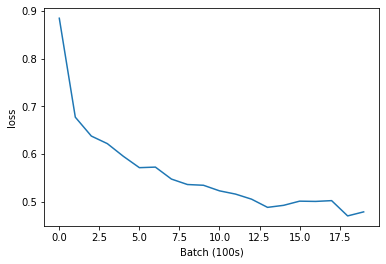

In [ ]:
# Replace the resnet input layer to take in grayscale images (1 input channel), since it was trained on color (3 input channels)
in_channels = 3
model_resnet.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Replace the resnet final layer with a new fully connected Linear layer we will train on our task
# Number of out units is number of classes (2)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 5)

# Train the model
n_epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet.parameters(), lr=0.001)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)
cost_path = train_model(model_resnet, criterion, optimizer, train_loader_resnet, n_epochs,device)

# Visualize the loss as the network trained
plt.plot(cost_path)
plt.xlabel('Batch (100s)')
plt.ylabel('loss')
plt.show()

In [ ]:
classes = ['2', '4']

In [ ]:
# Test the pre-trained model
acc,recall_vals,_, = test_model(model_resnet,test_loader_resnet,device)
print('Test set accuracy is {:.3f}'.format(acc))
for i in range(2):
    print('For class {}, recall is {}'.format(classes[i],recall_vals[i]))

Test set accuracy is 0.783
For class 2, recall is 0.7892156862745098
For class 4, recall is 0.7782426778242678


In [ ]:
!ls

In [ ]:
%cd /content/drive/"My Drive"/AIPI540

/content/drive/My Drive/AIPI540


In [ ]:
#torch.save(model_resnet.state_dict(),'deep_model_state.pt')

In [ ]:
filename = 'deep_fullmodel_new.pt'

# Save the entire model
torch.save(model_resnet, filename)

In [ ]:
url1 = 'https://github.com/Buuuuli/AIPI540_individual/blob/main/metadata/raw_metadata.csv?raw=true'

In [ ]:
url = 'https://github.com/Buuuuli/AIPI540_individual/blob/main/metadata/tidy_data.csv?raw=true'
df = pd.read_csv(url1,index_col=0)
print(df.head(5))

In [ ]:
df.dx.value_counts()

In [ ]:
#df['dx'] = df['dx'].map({"nv":0,"mel":1,"bkl":2,"bcc":3,"akiec":4,"vasc":5,"df":6})

In [ ]:
# group age
bins =[0,10,20,30,40,50,60,70,80,90]
labels = ['children','teenage','young','adult','midage','old1','old2','old3','older']

df['ageGroup'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

df = df.drop("age", axis=1)

In [ ]:
# {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}
dx_dict = dict(enumerate(df['dx'].astype('category').cat.categories))

# {0: 'confocal', 1: 'consensus', 2: 'follow_up', 3: 'histo'}
dx_type_dict = dict(enumerate(df['dx_type'].astype('category').cat.categories))

# {0: 'female', 1: 'male', 2: 'unknown'}
sex_dict = dict(enumerate(df['sex'].astype('category').cat.categories))

# {0: 'abdomen', 1: 'acral', 2: 'back', 3: 'chest', 4: 'ear',
# 5: 'face', 6: 'foot', 7: 'genital', 8: 'hand', 9: 'lower extremity',
# 10: 'neck', 11: 'scalp', 12: 'trunk', 13: 'unknown', 14: 'upper extremity'}
localization_dict = dict(enumerate(df['localization'].astype('category').cat.categories))

# {0: 'children', 1: 'teenage', 2: 'young', 3: 'adult', 4: 'midage',
# 5: 'old', 6: 'old2', 7: 'old3', 8: 'older'}
ageGroup_dict = dict(enumerate(df['ageGroup'].astype('category').cat.categories))

In [ ]:
# encode 'dx','dx_type','sex', 'localization'
for col in ['dx','dx_type','sex','localization','ageGroup']:
    df[col] = df[col].astype('category') # Convert to category type
    df[col] = df[col].cat.codes # Convert to numerical code

In [ ]:
df.dx.value_counts()

In [ ]:
#df['dx_type'] = df['dx_type'].map({"histo":0,"follow_up":1,"consensus":2,"confocal":3})

In [ ]:
#df.sex.value_counts()

In [ ]:
#df['sex'] = df['sex'].map({"male":0,"female":1,"unknow":2})

In [ ]:
#df.localization.value_counts()

In [ ]:
#df['localization'] = df['localization'].map({"back":0,"lower extremity":1,"trunk":2,"upper extremity":3,"abdomen":4,"face":5,"chest":6,
                                             "foot":7,"unkown":8,"neck":9,"scalp":10,"hand":11,"ear":12,"genital":13,"acral":14})

In [ ]:
#df.ageGroup.value_counts()

In [ ]:
#df['ageGroup'] = df['ageGroup'].map({"teenage":0,"children":1,"young":2,"older":3,"adult":4,"old3":5,"old2":6,
                                             "old1":7,"midage":8})

In [ ]:
#df.head()

In [ ]:
X_meta = newdf[['sex','localization','ageGroup']]

In [ ]:
y_meta = newdf[['dx']]

In [ ]:
X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(X_meta, y_meta, test_size=0.2,shuffle=True ,random_state=45)

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'min_samples_leaf':[1,3,10],'n_estimators':[100,1000],
          'max_features':[0.1,0.5,1.],'max_samples':[0.5,None],'max_depth':[2]}

model = RandomForestClassifier()
grid_search = GridSearchCV(model,params,cv=3,verbose=10)
grid_search.fit(X_train_meta,y_train_meta)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3; 1/36] START max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=1, n_estimators=100
[CV 1/3; 1/36] END max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=1, n_estimators=100;, score=0.602 total time=   0.2s
[CV 2/3; 1/36] START max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=1, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 1/36] END max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=1, n_estimators=100;, score=0.610 total time=   0.2s
[CV 3/3; 1/36] START max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=1, n_estimators=100
[CV 3/3; 1/36] END max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=1, n_estimators=100;, score=0.610 total time=   0.2s
[CV 1/3; 2/36] START max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 2/36] END max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=1, n_estimators=1000;, score=0.605 total time=   1.5s
[CV 2/3; 2/36] START max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 2/36] END max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=1, n_estimators=1000;, score=0.603 total time=   1.5s
[CV 3/3; 2/36] START max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 2/36] END max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=1, n_estimators=1000;, score=0.637 total time=   1.5s
[CV 1/3; 3/36] START max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=3, n_estimators=100
[CV 1/3; 3/36] END max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=3, n_estimators=100;, score=0.615 total time=   0.1s
[CV 2/3; 3/36] START max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=3, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 3/36] END max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=3, n_estimators=100;, score=0.614 total time=   0.2s
[CV 3/3; 3/36] START max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=3, n_estimators=100
[CV 3/3; 3/36] END max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=3, n_estimators=100;, score=0.621 total time=   0.2s
[CV 1/3; 4/36] START max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 4/36] END max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=3, n_estimators=1000;, score=0.614 total time=   1.5s
[CV 2/3; 4/36] START max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 4/36] END max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=3, n_estimators=1000;, score=0.608 total time=   1.4s
[CV 3/3; 4/36] START max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 4/36] END max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=3, n_estimators=1000;, score=0.647 total time=   1.4s
[CV 1/3; 5/36] START max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=10, n_estimators=100
[CV 1/3; 5/36] END max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=10, n_estimators=100;, score=0.619 total time=   0.1s
[CV 2/3; 5/36] START max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=10, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 5/36] END max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=10, n_estimators=100;, score=0.595 total time=   0.1s
[CV 3/3; 5/36] START max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=10, n_estimators=100
[CV 3/3; 5/36] END max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=10, n_estimators=100;, score=0.606 total time=   0.1s
[CV 1/3; 6/36] START max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 6/36] END max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=10, n_estimators=1000;, score=0.614 total time=   1.4s
[CV 2/3; 6/36] START max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 6/36] END max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=10, n_estimators=1000;, score=0.605 total time=   1.4s
[CV 3/3; 6/36] START max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 6/36] END max_depth=2, max_features=0.1, max_samples=0.5, min_samples_leaf=10, n_estimators=1000;, score=0.637 total time=   1.4s
[CV 1/3; 7/36] START max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=1, n_estimators=100
[CV 1/3; 7/36] END max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=1, n_estimators=100;, score=0.629 total time=   0.2s
[CV 2/3; 7/36] START max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=1, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 7/36] END max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=1, n_estimators=100;, score=0.612 total time=   0.2s
[CV 3/3; 7/36] START max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=1, n_estimators=100
[CV 3/3; 7/36] END max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=1, n_estimators=100;, score=0.606 total time=   0.2s
[CV 1/3; 8/36] START max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 8/36] END max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=1, n_estimators=1000;, score=0.600 total time=   1.5s
[CV 2/3; 8/36] START max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 8/36] END max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=1, n_estimators=1000;, score=0.603 total time=   1.5s
[CV 3/3; 8/36] START max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 8/36] END max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=1, n_estimators=1000;, score=0.613 total time=   1.4s
[CV 1/3; 9/36] START max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=3, n_estimators=100
[CV 1/3; 9/36] END max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=3, n_estimators=100;, score=0.620 total time=   0.2s
[CV 2/3; 9/36] START max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=3, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 9/36] END max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=3, n_estimators=100;, score=0.619 total time=   0.2s
[CV 3/3; 9/36] START max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=3, n_estimators=100
[CV 3/3; 9/36] END max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=3, n_estimators=100;, score=0.593 total time=   0.2s
[CV 1/3; 10/36] START max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 10/36] END max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=3, n_estimators=1000;, score=0.600 total time=   1.4s
[CV 2/3; 10/36] START max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 10/36] END max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=3, n_estimators=1000;, score=0.598 total time=   1.5s
[CV 3/3; 10/36] START max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 10/36] END max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=3, n_estimators=1000;, score=0.620 total time=   1.5s
[CV 1/3; 11/36] START max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=10, n_estimators=100
[CV 1/3; 11/36] END max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=10, n_estimators=100;, score=0.631 total time=   0.2s
[CV 2/3; 11/36] START max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=10, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 11/36] END max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=10, n_estimators=100;, score=0.603 total time=   0.2s
[CV 3/3; 11/36] START max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=10, n_estimators=100
[CV 3/3; 11/36] END max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=10, n_estimators=100;, score=0.630 total time=   0.2s
[CV 1/3; 12/36] START max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 12/36] END max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=10, n_estimators=1000;, score=0.627 total time=   1.4s
[CV 2/3; 12/36] START max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 12/36] END max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=10, n_estimators=1000;, score=0.605 total time=   1.5s
[CV 3/3; 12/36] START max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 12/36] END max_depth=2, max_features=0.1, max_samples=None, min_samples_leaf=10, n_estimators=1000;, score=0.618 total time=   1.5s
[CV 1/3; 13/36] START max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=1, n_estimators=100
[CV 1/3; 13/36] END max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=1, n_estimators=100;, score=0.627 total time=   0.2s
[CV 2/3; 13/36] START max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=1, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 13/36] END max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=1, n_estimators=100;, score=0.622 total time=   0.2s
[CV 3/3; 13/36] START max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=1, n_estimators=100
[CV 3/3; 13/36] END max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=1, n_estimators=100;, score=0.620 total time=   0.2s
[CV 1/3; 14/36] START max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 14/36] END max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=1, n_estimators=1000;, score=0.624 total time=   1.5s
[CV 2/3; 14/36] START max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 14/36] END max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=1, n_estimators=1000;, score=0.603 total time=   1.5s
[CV 3/3; 14/36] START max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 14/36] END max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=1, n_estimators=1000;, score=0.635 total time=   1.4s
[CV 1/3; 15/36] START max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=3, n_estimators=100
[CV 1/3; 15/36] END max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=3, n_estimators=100;, score=0.614 total time=   0.2s
[CV 2/3; 15/36] START max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=3, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 15/36] END max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=3, n_estimators=100;, score=0.597 total time=   0.2s
[CV 3/3; 15/36] START max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=3, n_estimators=100
[CV 3/3; 15/36] END max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=3, n_estimators=100;, score=0.643 total time=   0.2s
[CV 1/3; 16/36] START max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 16/36] END max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=3, n_estimators=1000;, score=0.610 total time=   1.5s
[CV 2/3; 16/36] START max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 16/36] END max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=3, n_estimators=1000;, score=0.608 total time=   1.5s
[CV 3/3; 16/36] START max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 16/36] END max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=3, n_estimators=1000;, score=0.633 total time=   1.5s
[CV 1/3; 17/36] START max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=10, n_estimators=100
[CV 1/3; 17/36] END max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=10, n_estimators=100;, score=0.619 total time=   0.2s
[CV 2/3; 17/36] START max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=10, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 17/36] END max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=10, n_estimators=100;, score=0.593 total time=   0.2s
[CV 3/3; 17/36] START max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=10, n_estimators=100
[CV 3/3; 17/36] END max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=10, n_estimators=100;, score=0.613 total time=   0.2s
[CV 1/3; 18/36] START max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 18/36] END max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=10, n_estimators=1000;, score=0.625 total time=   1.5s
[CV 2/3; 18/36] START max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 18/36] END max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=10, n_estimators=1000;, score=0.605 total time=   1.5s
[CV 3/3; 18/36] START max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 18/36] END max_depth=2, max_features=0.5, max_samples=0.5, min_samples_leaf=10, n_estimators=1000;, score=0.623 total time=   1.6s
[CV 1/3; 19/36] START max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=1, n_estimators=100
[CV 1/3; 19/36] END max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=1, n_estimators=100;, score=0.607 total time=   0.2s
[CV 2/3; 19/36] START max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=1, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 19/36] END max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=1, n_estimators=100;, score=0.615 total time=   0.2s
[CV 3/3; 19/36] START max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=1, n_estimators=100
[CV 3/3; 19/36] END max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=1, n_estimators=100;, score=0.616 total time=   0.2s
[CV 1/3; 20/36] START max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 20/36] END max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=1, n_estimators=1000;, score=0.600 total time=   1.5s
[CV 2/3; 20/36] START max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 20/36] END max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=1, n_estimators=1000;, score=0.603 total time=   1.5s
[CV 3/3; 20/36] START max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 20/36] END max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=1, n_estimators=1000;, score=0.615 total time=   1.5s
[CV 1/3; 21/36] START max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=3, n_estimators=100
[CV 1/3; 21/36] END max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=3, n_estimators=100;, score=0.631 total time=   0.2s
[CV 2/3; 21/36] START max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=3, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 21/36] END max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=3, n_estimators=100;, score=0.602 total time=   0.2s
[CV 3/3; 21/36] START max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=3, n_estimators=100
[CV 3/3; 21/36] END max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=3, n_estimators=100;, score=0.635 total time=   0.2s
[CV 1/3; 22/36] START max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 22/36] END max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=3, n_estimators=1000;, score=0.608 total time=   1.5s
[CV 2/3; 22/36] START max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 22/36] END max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=3, n_estimators=1000;, score=0.603 total time=   1.5s
[CV 3/3; 22/36] START max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 22/36] END max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=3, n_estimators=1000;, score=0.613 total time=   1.5s
[CV 1/3; 23/36] START max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=10, n_estimators=100
[CV 1/3; 23/36] END max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=10, n_estimators=100;, score=0.639 total time=   0.2s
[CV 2/3; 23/36] START max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=10, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 23/36] END max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=10, n_estimators=100;, score=0.600 total time=   0.2s
[CV 3/3; 23/36] START max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=10, n_estimators=100
[CV 3/3; 23/36] END max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=10, n_estimators=100;, score=0.632 total time=   0.2s
[CV 1/3; 24/36] START max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 24/36] END max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=10, n_estimators=1000;, score=0.614 total time=   1.5s
[CV 2/3; 24/36] START max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 24/36] END max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=10, n_estimators=1000;, score=0.605 total time=   1.5s
[CV 3/3; 24/36] START max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 24/36] END max_depth=2, max_features=0.5, max_samples=None, min_samples_leaf=10, n_estimators=1000;, score=0.615 total time=   1.6s
[CV 1/3; 25/36] START max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=1, n_estimators=100
[CV 1/3; 25/36] END max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=1, n_estimators=100;, score=0.636 total time=   0.2s
[CV 2/3; 25/36] START max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=1, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 25/36] END max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=1, n_estimators=100;, score=0.620 total time=   0.2s
[CV 3/3; 25/36] START max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=1, n_estimators=100
[CV 3/3; 25/36] END max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=1, n_estimators=100;, score=0.611 total time=   0.2s
[CV 1/3; 26/36] START max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 26/36] END max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=1, n_estimators=1000;, score=0.629 total time=   1.5s
[CV 2/3; 26/36] START max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 26/36] END max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=1, n_estimators=1000;, score=0.631 total time=   1.5s
[CV 3/3; 26/36] START max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 26/36] END max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=1, n_estimators=1000;, score=0.630 total time=   1.6s
[CV 1/3; 27/36] START max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=3, n_estimators=100
[CV 1/3; 27/36] END max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=3, n_estimators=100;, score=0.605 total time=   0.2s
[CV 2/3; 27/36] START max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=3, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 27/36] END max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=3, n_estimators=100;, score=0.625 total time=   0.2s
[CV 3/3; 27/36] START max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=3, n_estimators=100
[CV 3/3; 27/36] END max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=3, n_estimators=100;, score=0.613 total time=   0.2s
[CV 1/3; 28/36] START max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 28/36] END max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=3, n_estimators=1000;, score=0.632 total time=   1.5s
[CV 2/3; 28/36] START max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 28/36] END max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=3, n_estimators=1000;, score=0.622 total time=   1.5s
[CV 3/3; 28/36] START max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 28/36] END max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=3, n_estimators=1000;, score=0.610 total time=   1.6s
[CV 1/3; 29/36] START max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=10, n_estimators=100
[CV 1/3; 29/36] END max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=10, n_estimators=100;, score=0.625 total time=   0.2s
[CV 2/3; 29/36] START max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=10, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 29/36] END max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=10, n_estimators=100;, score=0.627 total time=   0.2s
[CV 3/3; 29/36] START max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=10, n_estimators=100
[CV 3/3; 29/36] END max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=10, n_estimators=100;, score=0.606 total time=   0.2s
[CV 1/3; 30/36] START max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 30/36] END max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=10, n_estimators=1000;, score=0.631 total time=   1.5s
[CV 2/3; 30/36] START max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 30/36] END max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=10, n_estimators=1000;, score=0.622 total time=   1.5s
[CV 3/3; 30/36] START max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 30/36] END max_depth=2, max_features=1.0, max_samples=0.5, min_samples_leaf=10, n_estimators=1000;, score=0.604 total time=   1.5s
[CV 1/3; 31/36] START max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=1, n_estimators=100
[CV 1/3; 31/36] END max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=1, n_estimators=100;, score=0.634 total time=   0.2s
[CV 2/3; 31/36] START max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=1, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 31/36] END max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=1, n_estimators=100;, score=0.625 total time=   0.2s
[CV 3/3; 31/36] START max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=1, n_estimators=100
[CV 3/3; 31/36] END max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=1, n_estimators=100;, score=0.635 total time=   0.2s
[CV 1/3; 32/36] START max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 32/36] END max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=1, n_estimators=1000;, score=0.617 total time=   1.6s
[CV 2/3; 32/36] START max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 32/36] END max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=1, n_estimators=1000;, score=0.627 total time=   1.6s
[CV 3/3; 32/36] START max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=1, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 32/36] END max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=1, n_estimators=1000;, score=0.608 total time=   1.6s
[CV 1/3; 33/36] START max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=3, n_estimators=100
[CV 1/3; 33/36] END max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=3, n_estimators=100;, score=0.619 total time=   0.2s
[CV 2/3; 33/36] START max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=3, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 33/36] END max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=3, n_estimators=100;, score=0.624 total time=   0.2s
[CV 3/3; 33/36] START max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=3, n_estimators=100
[CV 3/3; 33/36] END max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=3, n_estimators=100;, score=0.611 total time=   0.2s
[CV 1/3; 34/36] START max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 34/36] END max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=3, n_estimators=1000;, score=0.619 total time=   1.5s
[CV 2/3; 34/36] START max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 34/36] END max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=3, n_estimators=1000;, score=0.627 total time=   1.6s
[CV 3/3; 34/36] START max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=3, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 34/36] END max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=3, n_estimators=1000;, score=0.633 total time=   1.6s
[CV 1/3; 35/36] START max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=10, n_estimators=100
[CV 1/3; 35/36] END max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=10, n_estimators=100;, score=0.631 total time=   0.2s
[CV 2/3; 35/36] START max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=10, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 35/36] END max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=10, n_estimators=100;, score=0.608 total time=   0.2s
[CV 3/3; 35/36] START max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=10, n_estimators=100
[CV 3/3; 35/36] END max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=10, n_estimators=100;, score=0.628 total time=   0.2s
[CV 1/3; 36/36] START max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 36/36] END max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=10, n_estimators=1000;, score=0.615 total time=   1.6s
[CV 2/3; 36/36] START max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 36/36] END max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=10, n_estimators=1000;, score=0.624 total time=   1.6s
[CV 3/3; 36/36] START max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 36/36] END max_depth=2, max_features=1.0, max_samples=None, min_samples_leaf=10, n_estimators=1000;, score=0.632 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2], 'max_features': [0.1, 0.5, 1.0],
                         'max_samples': [0.5, None],
                         'min_samples_leaf': [1, 3, 10],
                         'n_estimators': [100, 1000]},
             verbose=10)

In [ ]:
grid_search.best_params_

{'max_depth': 2,
 'max_features': 1.0,
 'max_samples': None,
 'min_samples_leaf': 1,
 'n_estimators': 100}

In [ ]:
# Run the model using the parameters found from the grid search
rf_model_meta = RandomForestClassifier(criterion='gini',max_depth=2, min_samples_leaf=1,n_estimators=100,
                                 max_features=1,max_samples=None,random_state=0)
rf_model_meta.fit(X_train_meta, y_train_meta)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(max_depth=2, max_features=1, random_state=0)

In [ ]:
test_preds = rf_model_meta.predict(X_test_meta).reshape(len(X_test_meta),1)
test_acc = np.sum(test_preds==y_test_meta)/len(y_test_meta)


In [ ]:
test_acc

dx    0.58465
dtype: float64

In [ ]:
print(classification_report(y_test_meta, test_preds))

              precision    recall  f1-score   support

           2       0.65      0.62      0.63       204
           4       0.69      0.72      0.70       239

    accuracy                           0.67       443
   macro avg       0.67      0.67      0.67       443
weighted avg       0.67      0.67      0.67       443



In [ ]:
meta_test_0_5 = X_test_meta.iloc[0:5]

In [ ]:
meta_test_0_5

,dx_type,sex,localization,ageGroup
lesion_id,,,,
HAM_0001863,3,1,14,7
HAM_0003743,3,1,14,5
HAM_0000320,3,1,2,5
HAM_0000375,3,1,2,4
HAM_0005545,3,0,5,4


In [ ]:
test_0_5 = train_image_list_with_target[0:5]

In [ ]:
test_0_5

[(tensor([[[ 1.9235,  1.9407,  1.9407,  ...,  1.4440,  1.1529,  0.7933],
           [ 1.9235,  1.9407,  1.9235,  ...,  1.4269,  1.0844,  0.7591],
           [ 1.9064,  1.9407,  1.9920,  ...,  1.4269,  0.8447,  0.6392],
           ...,
           [ 1.8379,  1.9235,  1.9235,  ...,  1.5468,  1.4783,  1.4783],
           [ 1.7694,  1.8722,  1.8379,  ...,  1.5639,  1.4954,  1.4954],
           [ 1.8037,  1.7694,  1.7352,  ...,  1.5810,  1.5125,  1.4783]],
  
          [[ 0.7829,  0.7829,  0.8354,  ...,  0.0476, -0.0574, -0.3025],
           [ 0.7654,  0.7829,  0.8529,  ...,  0.0651, -0.1450, -0.3550],
           [ 0.7829,  0.7829,  0.8529,  ...,  0.0476, -0.3550, -0.4251],
           ...,
           [ 0.9230,  1.0105,  1.0105,  ...,  0.3978,  0.3277,  0.3102],
           [ 0.9055,  0.9580,  0.8880,  ...,  0.4503,  0.3452,  0.3277],
           [ 0.8880,  0.8529,  0.7829,  ...,  0.5028,  0.4153,  0.3452]],
  
          [[ 1.2457,  1.2980,  1.2805,  ...,  0.8971,  0.6705,  0.3219],
           

In [ ]:
image_testloader_0_5 = DataLoader(test_0_5,batch_size=batch_size, shuffle=False)

In [ ]:
# Test the pre-trained model
acc, recall_vals,prob = test_model(model_resnet,image_testloader_0_5,device)
print(prob)

print('Test set accuracy is {:.3f}'.format(acc))
for i in range(2):
    print('For class {}, recall is {}'.format(classes[i],recall_vals[i]))

[tensor([7.4711e-05, 6.6794e-05, 9.3479e-01, 9.1434e-05, 6.4974e-02]), tensor([5.4355e-04, 5.7287e-04, 4.2906e-01, 2.0090e-04, 5.6962e-01]), tensor([5.1108e-04, 2.5831e-04, 3.4864e-01, 3.9954e-04, 6.5019e-01]), tensor([0.0025, 0.0041, 0.4951, 0.0013, 0.4970]), tensor([2.8317e-04, 1.8900e-04, 7.1270e-01, 2.6217e-04, 2.8656e-01])]
Test set accuracy is 0.800
For class 2, recall is 0.6666666666666666
For class 4, recall is 1.0


In [ ]:
prob[2].tolist()[2]

0.3486405313014984

In [ ]:
prob[2][2]

0.3486405313014984

In [ ]:
DL_class2 = []
DL_class4 = []
list_list = []

In [ ]:
for j in list_list:
  DL_class2.append(j[2])

TypeError: ignored

In [ ]:
DL_class2 = []
DL_class4 = []
list_list = []
for i in prob:
  list_list.extend(i.tolist())

for j in list_list:
  DL_class2.append(j[2])
  DL_class4.append(j[4])

TypeError: ignored

In [ ]:
meta_subtest_prob = rf_model_meta.predict_proba(meta_test_0_5)

In [ ]:
meta_subtest_prob[1][0]

0.4305652011591832

In [ ]:
sub_test_predict = rf_model_meta.predict(meta_test_0_5)

In [ ]:
sub_test_predict

array([4, 4, 4, 4, 4], dtype=int8)

In [ ]:
def calc_feature_importances(model,feat_names,num_to_show):
    # Determine the relative importance of each feature using the random forest model
    importances = model.feature_importances_
    # Get an array of the indices that would sort "importances" in reverse order to get largest to smallest
    indices = np.argsort(importances)[::-1]
    ranked_feats = []
    for i in range(len(indices)):
        feat_name = feat_names[indices[i]]
        ranked_feats.append(feat_name)
    RF_ranking = pd.DataFrame()
    RF_ranking['Feat Index'] = indices
    RF_ranking['Feature'] = ranked_feats
    RF_ranking['Importance'] = np.sort(importances)[::-1]
    display(RF_ranking.iloc[:num_to_show,:])

    # Plot the importance value for each feature
    RF_ranking[:num_to_show][::-1].plot(x='Feature',y='Importance',kind='barh',figsize=(12,7),legend=False,title='RF Feature Importance')
    plt.show()
    return

,Feat Index,Feature,Importance
0,0,dx_type,0.428778
1,2,localization,0.255042
2,3,ageGroup,0.214002
3,1,sex,0.102179


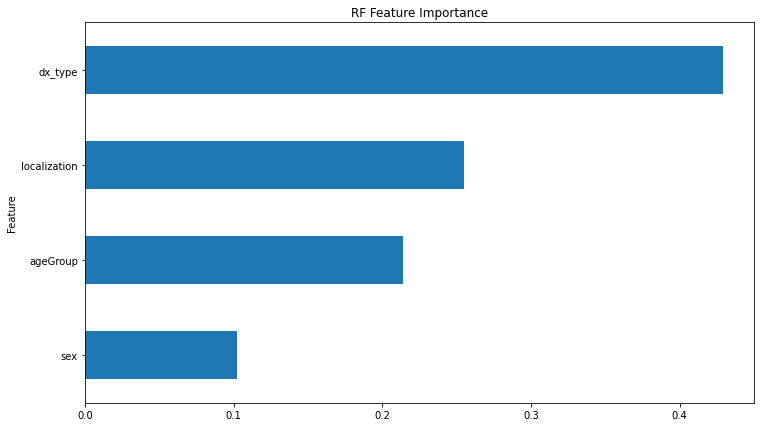

In [ ]:
top_feats = 30
calc_feature_importances(rf_model_meta,X_test_meta.columns,top_feats)

In [ ]:
%cd /content/drive/"My Drive"/AIPI540

/content/drive/My Drive/AIPI540


In [ ]:
filename = 'randomforest.sav'
pkl.dump(rf_model_meta, open(filename, 'wb'))

In [ ]:
!ls

ISIC_0024306.jpg  ISIC_0026810.jpg  ISIC_0029314.jpg  ISIC_0031818.jpg
ISIC_0024307.jpg  ISIC_0026811.jpg  ISIC_0029315.jpg  ISIC_0031819.jpg
ISIC_0024308.jpg  ISIC_0026812.jpg  ISIC_0029316.jpg  ISIC_0031820.jpg
ISIC_0024309.jpg  ISIC_0026813.jpg  ISIC_0029317.jpg  ISIC_0031821.jpg
ISIC_0024310.jpg  ISIC_0026814.jpg  ISIC_0029318.jpg  ISIC_0031822.jpg
ISIC_0024311.jpg  ISIC_0026815.jpg  ISIC_0029319.jpg  ISIC_0031823.jpg
ISIC_0024312.jpg  ISIC_0026816.jpg  ISIC_0029320.jpg  ISIC_0031824.jpg
ISIC_0024313.jpg  ISIC_0026817.jpg  ISIC_0029321.jpg  ISIC_0031825.jpg
ISIC_0024314.jpg  ISIC_0026818.jpg  ISIC_0029322.jpg  ISIC_0031826.jpg
ISIC_0024315.jpg  ISIC_0026819.jpg  ISIC_0029323.jpg  ISIC_0031827.jpg
ISIC_0024316.jpg  ISIC_0026820.jpg  ISIC_0029324.jpg  ISIC_0031828.jpg
ISIC_0024317.jpg  ISIC_0026821.jpg  ISIC_0029325.jpg  ISIC_0031829.jpg
ISIC_0024318.jpg  ISIC_0026822.jpg  ISIC_0029326.jpg  ISIC_0031830.jpg
ISIC_0024319.jpg  ISIC_0026823.jpg  ISIC_0029327.jpg  ISIC_0031831.jpg
ISIC_0